In [24]:
from keras.layers import Input, Dense, TimeDistributed, Embedding
from keras.layers import Concatenate, Reshape, Lambda, Multiply, multiply, concatenate
from keras.models import Model
from keras import backend as K

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

import tensorflow as tf
import numpy as np

from dataset_load import *
from human_terms_network import *

### Load

In [2]:
path = r"..\..\data\reviews_Amazon_Instant_Video_5.json.gz"

X, y = extract_review_amazon(path, 'reviewText')

In [3]:
y_label = np.asarray(y)

neutral_indices = np.where(y_label == 3)[0]
y_label[y_label<3] = 0
y_label[y_label>3] = 1

X_discarded = np.delete(X,neutral_indices)
y_discarded = np.delete(y_label, neutral_indices)

In [4]:
y_discarded[:100]

array([0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.])

In [5]:
X_discarded[:2]

array(["I had big expectations because I love English TV, in particular Investigative and detective stuff but this guy is really boring. It didn't appeal to me at all.",
       'I highly recommend this series. It is a must for anyone who is yearning to watch "grown up" television. Complex characters and plots to keep one totally involved. Thank you Amazin Prime.'],
      dtype='<U18152')

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, ShuffleSplit

# split
X_train_split, X_test_split, y_train, y_test = train_test_split(X_discarded, y_discarded, test_size=0.33, random_state=42)

# preprocessing
X_train_corpus_update = update_corpus_contraction(X_train_split)
X_test_corpus_update = update_corpus_contraction(X_test_split)

(75, 2)
corpus update start
corpus update end

(75, 2)
corpus update start
corpus update end



In [7]:
# count vectorizer
token = r"(?u)\b[\w\'/]+\b"
cv = CountVectorizer(lowercase=True, max_df=1.0, min_df=100, binary=True, token_pattern=token)
cv.set_params(ngram_range=(1,1))

cv.fit(X_train_split)

X_train = cv.transform(X_train_corpus_update)
X_test = cv.transform(X_test_corpus_update)

words = cv.get_feature_names()

In [8]:
print('+ : ', np.sum(y_train==1))
print('- : ', np.sum(y_train==0))

print('+ : ', np.sum(y_test==1))
print('- : ', np.sum(y_test==0))



+ :  19630
- :  2439
+ :  9706
- :  1164


In [9]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42)

clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9499297657347411
0.9271389144434222


In [17]:
weight = clf.coef_.flatten()
indices = np.argsort(weight)[::-1]

for i in indices[:50]:
    print("%s" %(words[i]))

reversed_indices = indices[::-1]
print()
for i in reversed_indices[:50]:
    print("%s" %(words[i]))

hooked
unexpected
hilarious
control
solving
refreshing
enjoyed
intense
incredible
develop
glad
awesome
intelligent
loves
lee
paced
perfectly
area
ending
renewed
favorite
growing
great
twists
thank
journey
today
whether
love
informative
holds
dramatic
edge
amazing
questions
truth
earlier
favorites
working
illiant
personalities
powerful
highly
disappoint
fantastic
tale
share
perfect
wow
pleasure

waste
boring
terrible
worst
pass
horrible
poor
taste
dull
dumb
unfortunately
sadly
awful
flat
fell
stupid
falls
nothing
boyfriend
worse
avoid
tried
instead
necessary
attempt
audience
value
moral
concept
tired
shots
slowly
directed
care
alien
supposed
sick
none
predictable
used
emotional
save
co
apparently
unless
premise
equally
ridiculous
beyond
finish


In [10]:
word_list, connotation = load_unigrams('./amazon-video-unigrams.txt', X_train_corpus_update, y_train)

In [11]:
y_train_agreement, y_test_agreement = generate_appearance(X_train_corpus_update, X_test_corpus_update, 
                                                          word_list, connotation)

In [12]:
y_train_agreement.shape

(22069, 30)

In [13]:
len(word_list)

30

In [19]:
htm = Human_Terms_Network(input_shape=X_train.shape[1], human_terms_shape=len(word_list))

# Plan
# Set the data
# including the y_agreement

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1499)              0         
_________________________________________________________________
tanh_output (Dense)          (None, 1)                 1500      
Total params: 1,500
Trainable params: 1,500
Non-trainable params: 0
_________________________________________________________________
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1499)         0                                            
_________________________________________

In [15]:
y_tanh_train = y_train
y_tanh_test = y_test

y_tanh_train[y_tanh_train==0] = -1
y_tanh_test[y_tanh_test==0] = -1

In [16]:
y_test.shape

(10870,)

In [20]:
htm.set_data(X_train[:1000], X_test[:1000], y_train_agreement[:1000], y_test_agreement[:1000], y_train[:1000], y_test[:1000])

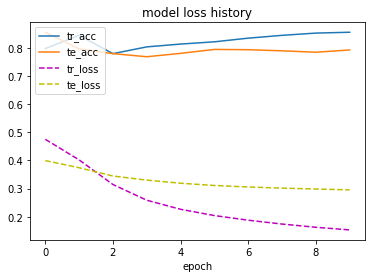

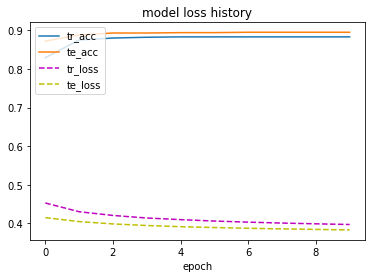

<Figure size 432x288 with 0 Axes>

In [21]:
htm.train(epochs=10)

In [ ]:
htm.base_history.history['acc']

In [82]:
# Print report on the word transparency
index = [9, 19]
def report():
    for i in index:
        print()
        bm = htm.base_combined.predict(X_test[i])
        
        cm = htm.combined.predict([X_test[i], 
                                np.reshape(y_test_agreement[i], (1,y_test_agreement.shape[1]))])
        
#         document_output = 'multiply'
#         document_predict = Model(inputs=combined_model.input,
#                                      outputs=combined_model.get_layer(document_output).output)
#         doc_output = document_predict.predict([np.reshape(data[i], (1,5)), 
#                                       ht_1_input[i], 
#                                       ht_2_input[i], 
#                                       ht_3_input[i], 
#                                       ht_4_input[i]])
        
        layer_name = 'concatenate'
        concat_after_relu = Model(inputs=htm.combined.input,
                                     outputs=htm.combined.get_layer(layer_name).output)
        concat_output = concat_after_relu.predict([X_test[i], 
                                np.reshape(y_test_agreement[i], (1,y_test_agreement.shape[1]))])
        
        print(X_test_corpus_update[i], '\n\n actual label : ', y_test[i], '\n predict from base model : ', bm.flatten(), '\n predict label : ', cm.flatten())
    
        for i,output in enumerate(concat_output.flatten()):
            if output != 0:
                print(word_list[i], output)

In [83]:
report()


love this program.  the actors are great and the story line is good.  i was glad to see season 4 coming. 

 actual label :  1.0 
 predict from base model :  [0.9865903] 
 predict label :  [0.998204]
glad 1.2505562
love 2.3989544
great 2.2678626

in a few simple words... i loved it. it was fresh and entertaining. my only critique is that 30 minutes seems a little short for a seemingly deep story driven show. print it... and make more i say. 

 actual label :  1.0 
 predict from base model :  [0.5381236] 
 predict label :  [0.9508625]
love 1.3084803
entertaining 1.012051


## See the colorweighted

In [28]:
import re
from coloredweighteddoc import ColoredWeightedDoc

In [34]:
from IPython import display
idx = 96
# idx = 9002
# bm = htm.base_combined.predict(X_test[idx])
        
# cm = htm.combined.predict([X_test[idx], 
#                              np.reshape(y_test_agreement[idx], (1,y_test_agreement.shape[1]))])
        
layer_name = 'concatenate'
concat_after_relu = Model(inputs=htm.combined.input,
                          outputs=htm.combined.get_layer(layer_name).output)
concat_output = concat_after_relu.predict([X_test[idx], np.reshape(y_test_agreement[idx], (1,y_test_agreement.shape[1]))])
        
print('actual label : ', y_test[idx], '\npredict from base model : ', bm.flatten(), '\npredict label : ', cm.flatten())
print()
for i,output in enumerate(concat_output.flatten()):
    if output != 0:
        print(word_list[i], output)


ht_weight = concat_output.flatten()
display.display(ColoredWeightedDoc(X_test_corpus_update[idx], word_list, ht_weight, binary = False))

actual label :  1.0 
predict from base model :  [0.9998344] 
predict label :  [0.5949186]

hilarious 0.8240383
informative 0.98478794


In [33]:
np.where(np.sum(ht_weight)==0)

(array([0], dtype=int64),)

In [88]:
word_list

['hooked',
 'paced',
 'glad',
 'battle',
 'perfect',
 'intense',
 'love',
 'enjoyed',
 'suspenseful',
 'effective',
 'favorites',
 'amazing',
 'disappoint',
 'outstanding',
 'laughed',
 'great',
 'excellent',
 'entertaining',
 'hilarious',
 'satisfying',
 'waste',
 'poorly',
 'terrible',
 'boring',
 'worst',
 'barely',
 'sadly',
 'paid',
 'none',
 'awful',
 'boyfriend',
 'equally',
 'poor',
 'horrible',
 'unbelievable',
 'dumb',
 'emotional',
 'disappointing',
 'purpose',
 'stupid',
 'lame',
 'worthy',
 'worse']

In [87]:
len(word_list)

43